# Library Load

In [1]:
import pandas as pd
import numpy as np

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.engine.topology import Layer
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras.models import Model, load_model, save_model, Sequential
from keras.layers import Embedding, Input, Dense, Conv1D, Dropout, Concatenate, Flatten, \
MaxPooling1D, Reshape, Bidirectional, LSTM, TimeDistributed, BatchNormalization

from keras import backend as K
from keras import optimizers
from keras import initializers, regularizers, constraints
from keras.utils.np_utils import to_categorical
from keras.utils import CustomObjectScope

import re
import nltk
from nltk import tokenize

from gensim.models import Word2Vec, KeyedVectors

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

from konlpy.tag import Mecab
import pickle as pkl
from tqdm import tqdm

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
C:\Users\user\.conda\envs\green\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
version = 'v2'

# Data Load

In [3]:
train = pd.read_csv('./data/train.csv')

In [4]:
# 과제명 -> title    요약문_연구내용 -> content     요약문_한글 키워드 -> keyword
train

,index,제출년도,사업명,사업_부처명,계속과제여부,내역사업명,과제명,요약문_연구목표,요약문_연구내용,요약문_기대효과,요약문_한글키워드,요약문_영문키워드,label
0,0,2016,농업기초기반연구,농촌진흥청,신규,농산물안전성연구,유전정보를 활용한 새로운 해충 분류군 동정기술 개발,○ 새로운 해충분류군의 동정기술 개발 및 유입확산 추적,(가) 외래 및 돌발해충의 발생조사 및 종 동정\n\n\n ○ 대상해충 : 최...,"○ 새로운 돌발 및 외래해충의 신속, 정확한 동정법 향상\n\n\n○ 돌발 및 외래...","뉴클레오티드 염기서열, 분자마커, 종 동정, 침샘, 전사체","nucleotide sequence, molecular marker, species...",24
1,1,2019,이공학학술연구기반구축(R&D),교육부,신규,지역대학우수과학자지원사업(1년~5년),대장암의 TRAIL 내성 표적 인자 발굴 및 TRAIL 반응 예측 유전자 지도 구축...,최종목표: TRAIL 감수성 표적 유전자를 발굴하고 내성제어 기전을 연구. 발굴된...,1차년도\n1) Microarray를 통한 선천적 TRAIL 내성 표적 후보 유전자...,"1) TRAIL 내성 특이적 표적분자를 발굴하고, 이를 이용한 TRAIL 효과 증진...","대장암,항암제 내성,세포사멸,유전자발굴","TRAIL,Colorectal cancer,TRAIL resistance,Apopt...",0
2,2,2016,중소기업기술혁신개발,중소기업청,신규,혁신기업기술개발,비목질계 셀룰로오스 식물자원을 활용한 기능성 부직포 및 고부가가치 뷰티케어 faci...,* 식물계자원 정련 및 최적 신서란 파이버 기초연구 개발\n\n\n* 소비자 및 바...,* 식물계자원 정련 및 최적 신서란 파이버 기초연구 개발\n\n\n- Tencel/...,* 국내 독자적인 비목질계 셀룰로오스 자원의 파이버 및 부직포 제조 등의 기술 확보...,"기능성 샐룰로오스 파이버,천연섬유,기능성 부직포,뷰티&amp;케어 제품,미용 솜","functional cellulose fiber,natural fiber,funct...",0
3,3,2018,창업성장기술개발(R&D),중소벤처기업부,신규,창업사업화연계과제,소화기 암 진단용 분자영상 형광프로브 개발,# 암특이적 바이오마커 발굴 및 바이오마커에 대한 프로브 개발\n\n\n1) 소화...,# 소화기 암 진단용 분자영상 형광프로브 개발\n\n\n- 국소 도포형 소화기 암 ...,# 암 진단기술의 차별성: 소화기 암 특이 프로브 개발\n\n\n- 최근 체외진단시...,"분자 진단,형광 조영제,프로브,항체,대장암","Molecular diagnosis,Fluorescence,probe,antibod...",0
4,4,2016,이공학개인기초연구지원,교육부,계속,기본연구지원,위암환자의 항암제반응예측을 위한 BRCA 발현검사,"수술이 불가능한 위암환자는 생존기간은 10개월 안팎에 지나지 않고, 항암화학요법에 ...",-In situ hybridization 검사의 정확성을 확인하기 위해 위암세포주 ...,-본 연구는 파라핀보관조직에서 in situ hybridization로 mRNA 및...,"BRCA,제자리부합법,조직미세배열,마이크로RNA,위암,항암제반응,젊은 연령/가족성 위암","BRCA,Insituhybridization,tissuemicroarray,micr...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
174299,174299,2016,개인연구지원,미래창조과학부,신규,중견연구,혈관내막 증식을 치료하기 위한 표적분자 발굴,"증식성 혈관질환과 염증반응과의 관련성이 높으나, 혈관평활근세포의 탈분화를 유도하는 ...",● 1차년: 혈관내막 증식과 관련된 표적분자 발굴 및 염증세포의 활성과 분화에 대한...,심혈관 질환 발생의 새로운 기전 규명뿐만 아니라 제어할 수 있는 새로운 방법을 탐...,"혈관내막 증식,혈관 개조,혈관평활근세포,염증세포,혈관염증,혈관평활근세포 탈분화,표적분자","Intimahyperplasia,Vascularremodeling,Vasculars...",0
174300,174300,2016,개인연구지원,미래창조과학부,신규,중견연구,삼킴곤란 개선을 위한 물성조절 식품시스템에서의 유동층과립 복합소재의 유변물성 변화 ...,삼킴곤란을 겪고 있는 고령자의 안전한 식품섭취는 삼킴에 적합한 유변물성을 가진 물성...,본 연구에서는 여러 가지 유변물성 측정기술을 이용하여 고령자의 삼킴곤란 개선을 위해...,○ 그 동안 연구되지 않은 다양한 물성조절 검복합 소재의 과립제형 및 유변물성 연구...,"삼킴곤란,유변물성,유동층과립,물리적 특성,검복합물","Swallowingdifficulty,Rheologicalproperty,Fludi...",0
174301,174301,2018,이공학학술연구기반구축(R&D),교육부,계속,이공분야학문후속세대양성_대통령POST_DOC펠로우쉽,식물 유전체 정보 고도화 및 핵심 유전자 군 진화연구,"지난 10년여 동안 100여종에 대한 식물 유전체 정보가 완성되어 공개되었지만, 애...",○ 공개된 식물 유전체 정보 및 대상 유전자 군 선발\n\n - 공개된 식물 유...,- 본 과제에서 개발한 annotation tool은 유전체 고도화 부분에서 가장 ...,"유전자 정보 고도화,대상 유전자 군 재분석,비교 유전체 진화 분석,공개 식물 유전체...","Gene model improvement,Target gene family re-a...",0
174302,174302,2019,수요자맞춤형육종자원대량신속발굴기술개발(R&D),농촌진흥청,신규,유용형질 대량 특성평가를 통한 육종모본 발굴,"콩 유전자원 내건성, 내습성 대량평가 체계구축 및 자원선발",1) 내건 및 내습성 유전자원 수집\n\n2) 내건성 자원평가 체계구축\n\n3) ...,[1차 년도(2019)] \n\n1) 내건 및 내습성 유전자원 수집\n\n○ 기존 ...,○ 내건성 및 내습성 특성평가 체계구축 및 우수자원 발굴로 내재해성 콩 품종육성 자...,"콩, 가공적성, 병 저항성, 내재해성, 콩모자이크바이러스","soybean, food application, resistance, biotic-...",23


# Preprocessing

In [5]:
def text_preprocessing(text_list):
    
    stopwords = ['은','는','이','가', '하','아','것','들','의','있','되','수','보','주','등','한'] #불용어 설정
    tokenizer = Mecab(dicpath=r'C:\mecab\mecab-ko-dic') #형태소 분석기 
    token_list = []
    
    for text in tqdm(text_list):
        text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ]","", text)
        token = tokenizer.morphs(text) #형태소 분석
        token = [t for t in token if t not in stopwords or type(t) != float] #형태소 분석 결과 중 stopwords에 해당하지 않는 것만 추출
        token_list.append(token)
        
    return token_list

In [6]:
train.isnull().sum()

index           0
제출년도            0
사업명             0
사업_부처명          0
계속과제여부          0
내역사업명           0
과제명             0
요약문_연구목표     3002
요약문_연구내용     3001
요약문_기대효과     3051
요약문_한글키워드    3028
요약문_영문키워드    3087
label           0
dtype: int64

In [7]:
train = train.fillna('NAN')
train.isnull().sum()

index        0
제출년도         0
사업명          0
사업_부처명       0
계속과제여부       0
내역사업명        0
과제명          0
요약문_연구목표     0
요약문_연구내용     0
요약문_기대효과     0
요약문_한글키워드    0
요약문_영문키워드    0
label        0
dtype: int64

In [8]:
train['tokenized_title'] = text_preprocessing(train['과제명'])
#train['tokenized_content'] = text_preprocessing(train['요약문_연구내용'])
#train['tokenized_keyword'] = text_preprocessing(train['요약문_한글키워드'])

train.tokenized_title = train.tokenized_title.apply(lambda x: ' '.join(x))
#train.tokenized_content = train.tokenized_content.apply(lambda x: ' '.join(x))
#train.tokenized_keyword = train.tokenized_keyword.apply(lambda x: ' '.join(x))

100%|███████████████████████████████████████████████████████████████████████| 174304/174304 [00:07<00:00, 24728.65it/s]


In [9]:
train['tokenized_title_len'] = train['tokenized_title'].apply(lambda x: len(x))
#train['tokenized_content_len'] = train['tokenized_content'].apply(lambda x: len(x))
#train['tokenized_keyword_len'] = train['tokenized_keyword'].apply(lambda x: len(x))

<AxesSubplot:xlabel='tokenized_title_len', ylabel='Density'>

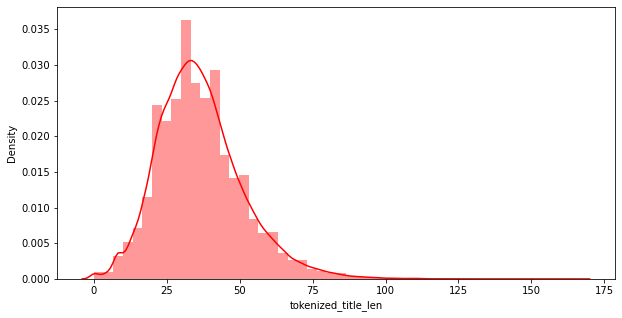

In [10]:
plt.figure(figsize=(10, 5))
sns.distplot(train['tokenized_title_len'], color='r')

In [11]:
train['tokenized_title_len'].describe()

count    174304.000000
mean         36.471928
std          14.673364
min           0.000000
25%          26.000000
50%          35.000000
75%          45.000000
max         166.000000
Name: tokenized_title_len, dtype: float64

## 과제명

In [12]:
word_len = []

for sentences in tqdm(train['tokenized_title']):
    for sentence in sentences.split('. '):
        word_len.append(sentence.split(' '))

100%|██████████████████████████████████████████████████████████████████████| 174304/174304 [00:00<00:00, 398800.99it/s]


In [13]:
word_len[1]

['대장암',
 '의',
 '내',
 '성표',
 '적',
 '인',
 '자발',
 '굴',
 '및',
 '반응',
 '예측',
 '유전자',
 '지도',
 '구축',
 '에',
 '관한',
 '연구']

In [14]:
sentence_num = []

for sentences in tqdm(train['tokenized_title']):
    sentence_num.append(sentences.split('. '))

100%|██████████████████████████████████████████████████████████████████████| 174304/174304 [00:00<00:00, 883963.72it/s]


In [15]:
sentence_num[7]

['임상오 믹스 정보 통합 개방 형 플랫 폼 구축 및 다기관 검증']

In [16]:
print('문서 내의 최대 문장 개수: ', max([len(i) for i in sentence_num]))
print('문서 내의 최소 문장 개수: ', min([len(i) for i in sentence_num]))
print('문서 내의 평균 문장 개수 :', sum(map(len, sentence_num))/len(sentence_num))
print('문서 내의 문장 개수 중앙값 :', np.median([len(i) for i in sentence_num]))

문서 내의 최대 문장 개수:  1
문서 내의 최소 문장 개수:  1
문서 내의 평균 문장 개수 : 1.0
문서 내의 문장 개수 중앙값 : 1.0


In [17]:
print('문장 내의 최대 단어 개수: ', max([len(j) for j in word_len]))
print('문장 내의 최소 단어 개수: ', min([len(j) for j in word_len]))
print('문장 내의 평균 단어 개수 :', sum(map(len, word_len))/len(word_len))
print('문장 내의 단어 개수 중앙값 :', np.median([len(j) for j in word_len]))

문장 내의 최대 단어 개수:  62
문장 내의 최소 단어 개수:  1
문장 내의 평균 단어 개수 : 12.847370111988251
문장 내의 단어 개수 중앙값 : 12.0


### HAN Hyper-Parameter

In [18]:
MAX_SENTENCES = 1
MAX_SENTENCE_LENGTH = 65
max_features = 200000

# Integer Encoding

In [19]:
han_tokenizer = Tokenizer(num_words=max_features, oov_token=True)
han_tokenizer.fit_on_texts(train['tokenized_title'])

with open('./tokenizer/han_tokenizer_{}.pkl'.format(version),'wb') as f:
    pkl.dump(han_tokenizer, f, protocol=pkl.HIGHEST_PROTOCOL)

In [20]:
max_nb_words = len(han_tokenizer.word_index) + 1

def doc2hierarchical(text, max_sentences = MAX_SENTENCES, max_sentence_length = MAX_SENTENCE_LENGTH):
    sentences = text.split('. ')
    tokenized_sentences = han_tokenizer.texts_to_sequences(sentences)
    tokenized_sentences = pad_sequences(tokenized_sentences, maxlen = max_sentence_length)

    pad_size = max_sentences - tokenized_sentences.shape[0]

    if pad_size <= 0:  # tokenized_sentences.shape[0] < max_sentences
        tokenized_sentences = tokenized_sentences[:max_sentences]
    else:
        tokenized_sentences = np.pad(tokenized_sentences, ((0, pad_size), (0, 0)), mode='constant', constant_values=0)
    
    return tokenized_sentences
            
def build_dataset(x_data, max_sentences = MAX_SENTENCES, max_sentence_length = MAX_SENTENCE_LENGTH, tokenizer = han_tokenizer):
    nb_instances = len(x_data)
    X_data = np.zeros((nb_instances, max_sentences, max_sentence_length), dtype='int32')
    for i, review in enumerate(x_data):
        tokenized_sentences = doc2hierarchical(review)
            
        X_data[i] = tokenized_sentences[None, ...]
        
    return X_data

In [21]:
data_title_x = build_dataset(train['tokenized_title'])

print("train_x_content.shape: {}".format(data_title_x.shape))

train_x_content.shape: (174304, 1, 65)


In [22]:
han_tokenizer.word_index

{True: 1,
 '개발': 2,
 '의': 3,
 '및': 4,
 '을': 5,
 '기술': 6,
 '연구': 7,
 '한': 8,
 '위한': 9,
 '를': 10,
 '성': 11,
 '기반': 12,
 '에': 13,
 '적': 14,
 '시스템': 15,
 '이용': 16,
 '형': 17,
 '화': 18,
 '용': 19,
 '과': 20,
 '이': 21,
 '는': 22,
 '분석': 23,
 '에서': 24,
 '통한': 25,
 '기능': 26,
 '활용': 27,
 '평가': 28,
 '소재': 29,
 '와': 30,
 '치료': 31,
 '하': 32,
 '구축': 33,
 '도': 34,
 '고': 35,
 '관리': 36,
 '사업': 37,
 '나노': 38,
 '인': 39,
 '가': 40,
 '모델': 41,
 '세포': 42,
 '환경': 43,
 '생산': 44,
 '적용': 45,
 '폼': 46,
 '공정': 47,
 '스마트': 48,
 '플랫': 49,
 '물질': 50,
 '구조': 51,
 '로': 52,
 '된': 53,
 '조절': 54,
 '규명': 55,
 '대한': 56,
 '진단': 57,
 '효율': 58,
 '개선': 59,
 '복합': 60,
 '정보': 61,
 '전': 62,
 '데이터': 63,
 '특성': 64,
 '향상': 65,
 '제조': 66,
 '에너지': 67,
 '장치': 68,
 '질환': 69,
 '의한': 70,
 '제어': 71,
 '가능': 72,
 '지원': 73,
 '융합': 74,
 '성능': 75,
 '통합': 76,
 '바이오': 77,
 '제품': 78,
 '서비스': 79,
 '제': 80,
 '예측': 81,
 '비': 82,
 '산업': 83,
 '관한': 84,
 '응용': 85,
 '센서': 86,
 '효과': 87,
 '지역': 88,
 '안전': 89,
 '영상': 90,
 '설계': 91,
 '유전자': 92,
 '발굴': 93,
 '활성'

In [23]:
han_word_index = han_tokenizer.word_index
print('Total %s unique tokens.' % len(han_word_index))

Total 35832 unique tokens.


# Word2Vec

In [24]:
embed_size = 100

In [25]:
emb_model = Word2Vec.load('./data/word2vec_mecab.model')
han_embedding_matrix = np.zeros((len(han_word_index) + 1, embed_size))

In [26]:
def get_vector(word):
    if word == True:
        return None
    elif word in emb_model.wv:
        return emb_model.wv[word]
    else:
        return None

In [27]:
absent_words = 0

for word, i in han_word_index.items(): 
    temp = get_vector(word) 
    if temp is not None:
        han_embedding_matrix[i] = temp
    else:
        absent_words += 1
        
print('Total absent words are', absent_words, 'which is', "%0.2f" % (absent_words * 100 / len(han_word_index)), '% of total words')

Total absent words are 1 which is 0.00 % of total words


In [28]:
embedding_layer_content = Embedding(len(han_word_index) + 1, 
                                    embed_size,
                                    weights = [han_embedding_matrix],
                                    input_length = MAX_SENTENCE_LENGTH,
                                    trainable=False)

# Feature Encoding

In [29]:
train_dum = train[['제출년도', '사업_부처명', '계속과제여부']]
train_dum

,제출년도,사업_부처명,계속과제여부
0,2016,농촌진흥청,신규
1,2019,교육부,신규
2,2016,중소기업청,신규
3,2018,중소벤처기업부,신규
4,2016,교육부,계속
...,...,...,...
174299,2016,미래창조과학부,신규
174300,2016,미래창조과학부,신규
174301,2018,교육부,계속
174302,2019,농촌진흥청,신규


In [30]:
train_dum.dtypes

제출년도       int64
사업_부처명    object
계속과제여부    object
dtype: object

In [31]:
train_dum_v1 = train_dum.astype('category')
train_dum_v1

,제출년도,사업_부처명,계속과제여부
0,2016,농촌진흥청,신규
1,2019,교육부,신규
2,2016,중소기업청,신규
3,2018,중소벤처기업부,신규
4,2016,교육부,계속
...,...,...,...
174299,2016,미래창조과학부,신규
174300,2016,미래창조과학부,신규
174301,2018,교육부,계속
174302,2019,농촌진흥청,신규


In [32]:
train_dum_v1.dtypes

제출년도      category
사업_부처명    category
계속과제여부    category
dtype: object

In [33]:
train_dum_v1['제출년도'] = train_dum_v1['제출년도'].cat.codes
train_dum_v1['사업_부처명'] = train_dum_v1['사업_부처명'].cat.codes
train_dum_v1['계속과제여부'] = train_dum_v1['계속과제여부'].cat.codes
train_dum_v1

,제출년도,사업_부처명,계속과제여부
0,0,8,1
1,3,2,1
2,0,20,1
3,2,21,1
4,0,2,0
...,...,...,...
174299,0,12,1
174300,0,12,1
174301,2,2,0
174302,3,8,1


In [34]:
scaler = MinMaxScaler()

In [35]:
train_dum_v1_scale = scaler.fit_transform(train_dum_v1)
train_dum_v1_scale

array([[0.        , 0.2962963 , 1.        ],
       [1.        , 0.07407407, 1.        ],
       [0.        , 0.74074074, 1.        ],
       ...,
       [0.66666667, 0.07407407, 0.        ],
       [1.        , 0.2962963 , 1.        ],
       [1.        , 0.07407407, 1.        ]])

# Label Encoding

In [36]:
Y = pd.get_dummies(train['label']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (174304, 46)


In [37]:
Y

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=uint8)

# Data Split

In [38]:
VALIDATION_SPLIT = 0.4

In [39]:
indices = np.arange(data_title_x.shape[0])
np.random.shuffle(indices)
data_title = data_title_x[indices]
#data_content = data_content_x[indices]
#data_keyword = data_keyword[indices]

Y = Y[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data_title_x.shape[0])

x_train_title = data_title[:-nb_validation_samples]
#x_train_content = data_content_x[:-nb_validation_samples]
#x_train_keyword = data_keyword[:-nb_validation_samples]
x_train_cat = train_dum_v1_scale[:-nb_validation_samples]
y_train = Y[:-nb_validation_samples]

x_val_title = data_title[-nb_validation_samples:]
#x_val_content = data_content_x[-nb_validation_samples:]
#x_val_keyword = data_keyword[-nb_validation_samples:]
x_val_cat = train_dum_v1_scale[-nb_validation_samples:]
y_val = Y[-nb_validation_samples:]

print('Number of positive and negative reviews in traing and validation set')
print(y_train.sum(axis=0).tolist())
print(y_val.sum(axis=0).tolist())

Number of positive and negative reviews in traing and validation set
[85583, 767, 158, 86, 33, 1008, 48, 62, 201, 59, 386, 113, 163, 341, 1009, 104, 302, 86, 952, 2952, 604, 304, 97, 1094, 2153, 497, 183, 384, 231, 612, 133, 543, 164, 322, 326, 174, 633, 162, 151, 127, 267, 37, 32, 223, 53, 664]
[56988, 494, 117, 57, 24, 690, 30, 51, 138, 47, 272, 87, 105, 234, 663, 61, 204, 68, 598, 1986, 455, 192, 51, 746, 1367, 313, 133, 236, 218, 416, 101, 379, 96, 211, 197, 117, 427, 104, 111, 75, 174, 30, 19, 128, 38, 473]


In [40]:
from sklearn.utils import class_weight

In [41]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(train['label']), np.array(train['label']))

# HAN

In [50]:
class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'W_regularizer': self.W_regularizer,
            'u_regularizer': self.u_regularizer,
            'b_regularizer': self.b_regularizer,
            'W_constraint': self.W_constraint,
            'u_constraint': self.u_constraint,
            'b_constraint': self.b_constraint,
            'bias': self.bias
        })
        return config

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [51]:
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatibl|e with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

In [52]:
REG_PARAM = 1e-13
l2_reg = regularizers.l2(REG_PARAM)

In [53]:
# HAN
word_input1 = Input(shape=(MAX_SENTENCE_LENGTH,), dtype='float32')
word_sequences = embedding_layer_content(word_input1)
word_lstm = Bidirectional(LSTM(100, return_sequences=True, kernel_regularizer=l2_reg))(word_sequences)
word_dense = TimeDistributed(Dense(200, kernel_regularizer=l2_reg))(word_lstm)
word_att = AttentionWithContext()(word_dense)
wordEncoder = Model(word_input1, word_att)

# then, build a document encoder
sent_input = Input(shape=(MAX_SENTENCES, MAX_SENTENCE_LENGTH), dtype='float32')
sent_encoder = TimeDistributed(wordEncoder)(sent_input)
sent_lstm = Bidirectional(LSTM(100, return_sequences=True, kernel_regularizer=l2_reg))(sent_encoder)
sent_dense = TimeDistributed(Dense(200, kernel_regularizer=l2_reg))(sent_lstm)
sent_att = AttentionWithContext()(sent_dense)

# finally, add fc layers for classification
x1 = BatchNormalization()(sent_att)
x1 = Dense(128, activation='relu')(x1)


# feature1, 2, 3
input2 = Input(shape=(3,), dtype='float32')
x2 = Dense(30, activation='relu')(input2)


# HAN
concat = Concatenate()([x1, x2])
dense = Dropout(0.5)(Dense(128, activation= 'relu', kernel_regularizer=l2_reg)(concat))
preds = Dense(46, activation='softmax')(dense)


model = Model(inputs = [sent_input, input2], outputs = preds)


model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1, 65)        0                                            
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 1, 200)       3824700     input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 1, 200)       240800      time_distributed_2[0][0]         
__________________________________________________________________________________________________
time_distributed_3 (TimeDistrib (None, 1, 200)       40200       bidirectional_2[0][0]            
____________________________________________________________________________________________

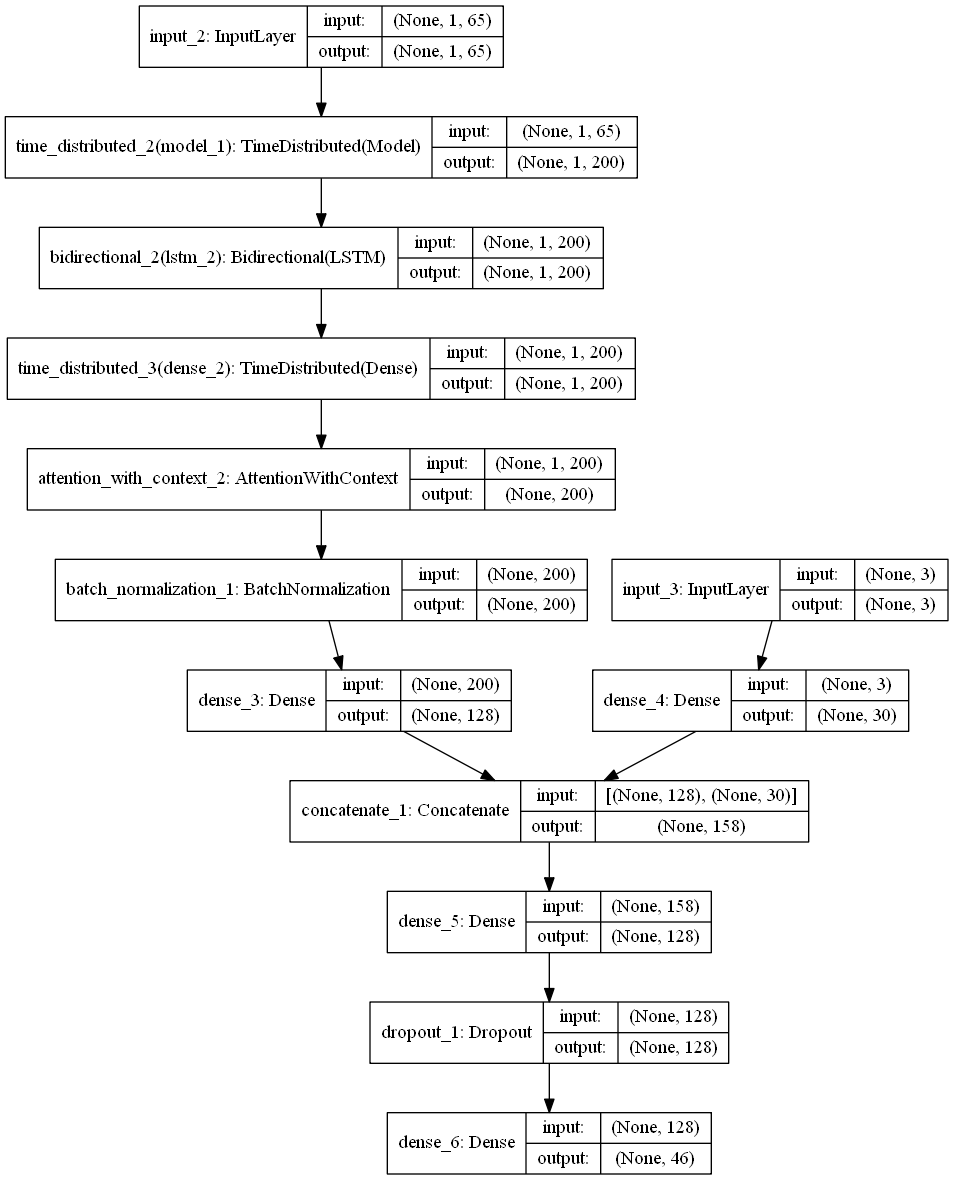

In [54]:
%matplotlib inline

SVG(model_to_dot(model, show_shapes=True, dpi=100).create(prog='dot', format='svg'))

plot_model(model, show_shapes=True, to_file='./img/CNN_{}.png'.format(version))

In [55]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [56]:
es = EarlyStopping(monitor='val_loss', patience=5)

mc = ModelCheckpoint('./save_models/han_{}'.format(version) + '_{epoch:02d}_{val_loss:.5f}.h5',
                             verbose=0,
                             monitor='val_loss',
                             save_best_only=False,
                             mode='auto')

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m])

In [57]:
history = model.fit([x_train_title, x_train_cat], y_train,
                    validation_data = ([x_val_title, x_val_cat], y_val),
                    class_weight = class_weights,
                    epochs = 50,
                    batch_size = 64,
                    callbacks = [es, mc])

Train on 104583 samples, validate on 69721 samples
Epoch 1/50
104583/104583 [==============================] - 394s 4ms/step - loss: 0.7447 - f1_m: 0.8173 - val_loss: 0.5709 - val_f1_m: 0.8490
Epoch 2/50
104583/104583 [==============================] - 395s 4ms/step - loss: 0.5733 - f1_m: 0.8442 - val_loss: 0.5254 - val_f1_m: 0.8558
Epoch 3/50
104583/104583 [==============================] - 398s 4ms/step - loss: 0.5172 - f1_m: 0.8528 - val_loss: 0.4887 - val_f1_m: 0.8636
Epoch 4/50
104583/104583 [==============================] - 395s 4ms/step - loss: 0.4823 - f1_m: 0.8603 - val_loss: 0.4818 - val_f1_m: 0.8620
Epoch 5/50
104583/104583 [==============================] - 395s 4ms/step - loss: 0.4517 - f1_m: 0.8667 - val_loss: 0.4615 - val_f1_m: 0.8694
Epoch 6/50
104583/104583 [==============================] - 396s 4ms/step - loss: 0.4230 - f1_m: 0.8742 - val_loss: 0.4601 - val_f1_m: 0.8718
Epoch 7/50
104583/104583 [==============================] - 396s 4ms/step - loss: 0.3941 - f1_m: 

In [58]:
print(history.history.keys())

dict_keys(['val_loss', 'val_f1_m', 'loss', 'f1_m'])


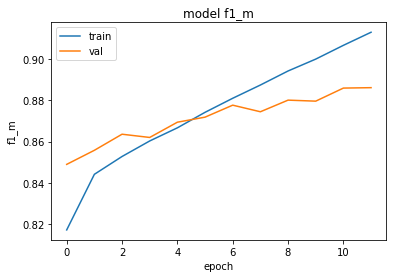

In [59]:
# summarize history for accuracy
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('model f1_m')
plt.ylabel('f1_m')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

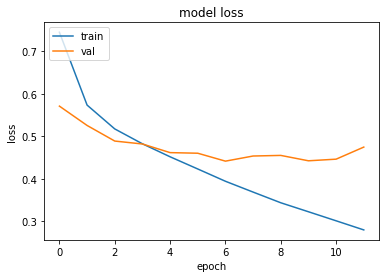

In [60]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Inference

In [61]:
test = pd.read_csv('./data/test.csv')

In [62]:
test = test.fillna('NAN')

In [63]:
with CustomObjectScope({'AttentionWithContext': AttentionWithContext, 'f1_m': f1_m}):
    model = load_model('./save_models/han_v2_11_0.44610.h5')

In [64]:
with open('./tokenizer/han_tokenizer_{}.pkl'.format(version),'rb') as f:
    han_tokenizer = pkl.load(f)
    
f.close()

In [65]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [66]:
test['tokenized_title'] = text_preprocessing(test['과제명'])
#test['tokenized_content'] = text_preprocessing(test['요약문_연구내용'])
#test['tokenized_keyword'] = text_preprocessing(test['요약문_한글키워드'])

test.tokenized_title = test.tokenized_title.apply(lambda x: ' '.join(x))
#test.tokenized_content = test.tokenized_content.apply(lambda x: ' '.join(x))
#test.tokenized_keyword = test.tokenized_keyword.apply(lambda x: ' '.join(x))

100%|█████████████████████████████████████████████████████████████████████████| 43576/43576 [00:01<00:00, 24437.59it/s]


## HAN

In [67]:
max_nb_words = len(han_tokenizer.word_index) + 1

def doc2hierarchical(text, max_sentences = MAX_SENTENCES, max_sentence_length = MAX_SENTENCE_LENGTH):
    sentences = text.split('. ')
    tokenized_sentences = han_tokenizer.texts_to_sequences(sentences)
    tokenized_sentences = pad_sequences(tokenized_sentences, maxlen = max_sentence_length)

    pad_size = max_sentences - tokenized_sentences.shape[0]

    if pad_size <= 0:  # tokenized_sentences.shape[0] < max_sentences
        tokenized_sentences = tokenized_sentences[:max_sentences]
    else:
        tokenized_sentences = np.pad(tokenized_sentences, ((0, pad_size), (0, 0)), mode='constant', constant_values=0)
    
    return tokenized_sentences
            
def build_dataset(x_data, max_sentences = MAX_SENTENCES, max_sentence_length = MAX_SENTENCE_LENGTH, tokenizer = han_tokenizer):
    nb_instances = len(x_data)
    X_data = np.zeros((nb_instances, max_sentences, max_sentence_length), dtype='int32')
    for i, review in enumerate(x_data):
        tokenized_sentences = doc2hierarchical(review)
            
        X_data[i] = tokenized_sentences[None, ...]
    
    return X_data


data_title = build_dataset(test['tokenized_title'])

print("train_x_content.shape: {}".format(data_title.shape))

train_x_content.shape: (43576, 1, 65)


In [68]:
han_word_index = han_tokenizer.word_index
print('Total %s unique tokens.' % len(han_word_index))

Total 35832 unique tokens.


In [69]:
test_dum = test[['제출년도', '사업_부처명', '계속과제여부']]
test_dum

,제출년도,사업_부처명,계속과제여부
0,2016,산업통상자원부,신규
1,2018,과학기술정보통신부,계속
2,2017,과학기술정보통신부,계속
3,2018,중소벤처기업부,신규
4,2019,교육부,계속
...,...,...,...
43571,2016,농림축산식품부,계속
43572,2017,산업통상자원부,신규
43573,2016,미래창조과학부,계속
43574,2019,과학기술정보통신부,계속


In [70]:
test_dum.dtypes

제출년도       int64
사업_부처명    object
계속과제여부    object
dtype: object

In [71]:
test_dum_v1 = test_dum.astype('category')
test_dum_v1

,제출년도,사업_부처명,계속과제여부
0,2016,산업통상자원부,신규
1,2018,과학기술정보통신부,계속
2,2017,과학기술정보통신부,계속
3,2018,중소벤처기업부,신규
4,2019,교육부,계속
...,...,...,...
43571,2016,농림축산식품부,계속
43572,2017,산업통상자원부,신규
43573,2016,미래창조과학부,계속
43574,2019,과학기술정보통신부,계속


In [72]:
test_dum_v1.dtypes

제출년도      category
사업_부처명    category
계속과제여부    category
dtype: object

In [73]:
test_dum_v1['제출년도'] = test_dum_v1['제출년도'].cat.codes
test_dum_v1['사업_부처명'] = test_dum_v1['사업_부처명'].cat.codes
test_dum_v1['계속과제여부'] = test_dum_v1['계속과제여부'].cat.codes
test_dum_v1

,제출년도,사업_부처명,계속과제여부
0,0,16,1
1,2,1,0
2,1,1,0
3,2,21,1
4,3,2,0
...,...,...,...
43571,0,7,0
43572,1,16,1
43573,0,12,0
43574,3,1,0


In [74]:
test_dum_v1_scale = scaler.transform(test_dum_v1)
test_dum_v1_scale

array([[0.        , 0.59259259, 1.        ],
       [0.66666667, 0.03703704, 0.        ],
       [0.33333333, 0.03703704, 0.        ],
       ...,
       [0.        , 0.44444444, 0.        ],
       [1.        , 0.03703704, 0.        ],
       [0.33333333, 0.59259259, 1.        ]])

## Prediction

In [75]:
pred_test = model.predict([data_title, test_dum_v1_scale], batch_size = 64)

In [76]:
pred_test.shape

(43576, 46)

In [77]:
pred = np.argmax(pred_test, axis=1)

In [78]:
pred.shape

(43576,)

# Submission

In [79]:
sample_submission = pd.read_csv('./submission/sample_submission.csv')

In [80]:
sample_submission['label'] = pred
sample_submission.to_csv('./submission/han_{}.csv'.format(version), index=False)

In [81]:
sample_submission['label'].value_counts()

0     37416
19      741
24      619
14      392
5       381
23      371
18      358
1       307
31      245
36      232
29      225
45      219
25      207
34      153
13      148
27      139
16      134
40      127
33      119
10      114
21      110
8        76
2        70
20       63
28       63
15       51
43       48
37       47
12       46
11       44
35       37
3        35
32       32
30       30
7        26
39       25
38       25
22       19
9        19
26       19
6        16
44       15
4        12
17        1
Name: label, dtype: int64